In [741]:
import numpy as np
import pandas as pd
from numpy import hstack
from numpy import concatenate
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Masking
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [742]:
df = pd.read_csv('data/daily.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE            datetime64[ns]
TEAMNAME                object
USERCOUNT                int64
SECONDSSPENT             int64
QUANTITY                 int64
VOLUME                 float64
WEIGHT                 float64
PRICE                  float64
dtype: object

In [743]:
df = df[(df['DATE'] > '2022-08-10')]
# df = df[(df['DATE'] != '2020-07-22')]

In [744]:
df.columns

Index(['DATE', 'TEAMNAME', 'USERCOUNT', 'SECONDSSPENT', 'QUANTITY', 'VOLUME',
       'WEIGHT', 'PRICE'],
      dtype='object')

In [745]:
df = df[df['TEAMNAME'] != 'ID9']

df.index = pd.DatetimeIndex(df['DATE'])
df = df.drop(columns=['DATE'])
s = pd.DataFrame(index=pd.date_range(df.index.min(), df.index.max(), freq='D').difference(df.index), columns=df.columns)
df = pd.concat([df,s]).fillna(0).sort_index()
df['DATE'] = df.index
df = df.reset_index(drop=True)
df['TEAMNAME'] = df['TEAMNAME'].replace(0, 'DP1')

df_multi_index = pd.MultiIndex.from_product([df['DATE'].unique(), df['TEAMNAME'].unique()], names=['DATE', 'TEAMNAME'])
df = df.set_index(['DATE', 'TEAMNAME']).reindex(df_multi_index, fill_value=0).reset_index()
df

# write to csv
df.to_csv('data/try.csv')

# df_dp = df.loc[df['TEAMNAME'].isin(['DP1', 'DP2']), :]
# df_rest = df.loc[df['TEAMNAME'].isin(['DD', 'HD', 'HP1', 'HP2']), :].groupby('DATE').sum().reset_index()
# df_rest['TEAMNAME'] = 'REST'
# df = pd.concat([df_dp, df_rest])
# df = df.sort_values(by=['DATE', 'TEAMNAME'])

In [746]:
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day

In [747]:
codes = dict(zip(df['TEAMNAME'].unique(), range(0, len(df['TEAMNAME'].unique()))))
codes

{'DP2': 0, 'DP1': 1, 'HP1': 2, 'HP2': 3, 'DD': 4, 'HD': 5}

In [748]:
# codes = {'DD': 0.001, 'DP2': 0.0004, 'DP1': 0.00035, 'HP1': 0.00005, 'HP2': 0.0001, 'HD': 0.0002}
# df['TEAMNAME'] = 1 / df['TEAMNAME'].map(codes)
# print(codes)
# df

In [749]:
seconds_spent = df['SECONDSSPENT'].values.reshape(-1, 1)
user_count = df['USERCOUNT'].values.reshape(-1, 1)
quantity = df['QUANTITY'].values.reshape(-1, 1)
volume = df['VOLUME'].values.reshape(-1, 1)
weight = df['WEIGHT'].values.reshape(-1, 1)
price = df['PRICE'].values.reshape(-1, 1)
team_name = df['TEAMNAME'].values.reshape(-1, 1)
date = df['DATE'].values.reshape(-1, 1)
month = df['MONTH'].values.reshape(-1, 1)
day = df['DAY'].values.reshape(-1, 1)

# one hot encode TEAMNAME
onehot_encoder = OneHotEncoder(sparse_output=False)
team_name = onehot_encoder.fit_transform(df[['TEAMNAME']])
date = onehot_encoder.fit_transform(date)
month = onehot_encoder.fit_transform(month)
day = onehot_encoder.fit_transform(day)

scaler = MinMaxScaler(feature_range=(0, 1))
# seconds_spent = scaler.fit_transform(seconds_spent)
# user_count = scaler.fit_transform(user_count)
# quantity = scaler.fit_transform(quantity)
# volume = scaler.fit_transform(volume)
# weight = scaler.fit_transform(weight)
# price = scaler.fit_transform(price)

dataset = scaler.fit_transform(hstack((user_count, quantity, volume, weight, price, team_name, seconds_spent)))
team_name.shape


(2460, 6)

In [750]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2214, 1, 11) (2214,) (246, 1, 11) (246,)


Epoch 1/300


2023-12-05 03:54:12.998841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2214]
	 [[{{node Placeholder/_11}}]]
2023-12-05 03:54:12.999107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2214]
	 [[{{node Placeholder/_11}}]]
2023-12-05 03:54:15.381624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [24

35/35 - 4s - loss: 0.4089 - val_loss: 0.4239 - 4s/epoch - 109ms/step
Epoch 2/300
35/35 - 0s - loss: 0.4076 - val_loss: 0.4224 - 75ms/epoch - 2ms/step
Epoch 3/300
35/35 - 0s - loss: 0.4063 - val_loss: 0.4208 - 71ms/epoch - 2ms/step
Epoch 4/300
35/35 - 0s - loss: 0.4049 - val_loss: 0.4192 - 67ms/epoch - 2ms/step
Epoch 5/300
35/35 - 0s - loss: 0.4037 - val_loss: 0.4175 - 68ms/epoch - 2ms/step
Epoch 6/300
35/35 - 0s - loss: 0.4024 - val_loss: 0.4158 - 68ms/epoch - 2ms/step
Epoch 7/300
35/35 - 0s - loss: 0.4010 - val_loss: 0.4140 - 67ms/epoch - 2ms/step
Epoch 8/300
35/35 - 0s - loss: 0.3995 - val_loss: 0.4122 - 69ms/epoch - 2ms/step
Epoch 9/300
35/35 - 0s - loss: 0.3979 - val_loss: 0.4104 - 69ms/epoch - 2ms/step
Epoch 10/300
35/35 - 0s - loss: 0.3964 - val_loss: 0.4084 - 70ms/epoch - 2ms/step
Epoch 11/300
35/35 - 0s - loss: 0.3952 - val_loss: 0.4065 - 68ms/epoch - 2ms/step
Epoch 12/300
35/35 - 0s - loss: 0.3932 - val_loss: 0.4044 - 71ms/epoch - 2ms/step
Epoch 13/300
35/35 - 0s - loss: 0.391

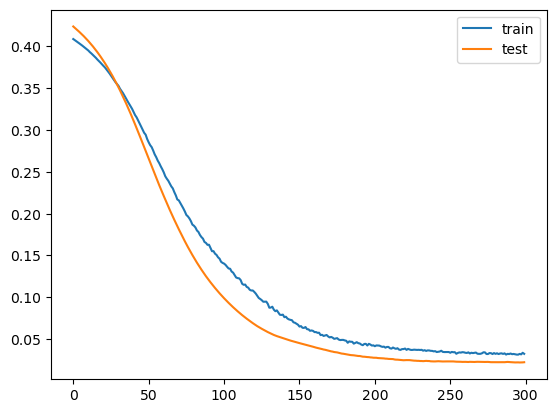

In [751]:
# design network
np.random.seed(1234)
tf.random.set_seed(1234)

tf.keras.utils.set_random_seed(1234)
tf.config.experimental.enable_op_determinism()

optim = optimizers.Adam(lr=0.0001, decay=1e-6)

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer=optim)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [752]:
# make a prediction
yhat = model.predict(test_X)
X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for prediction
dataset_yhat = concatenate((X, yhat), axis=1)
dataset_yhat = scaler.inverse_transform(dataset_yhat)
inv_yhat = dataset_yhat[:, -1]

# invert scaling for actual
y = test_y.reshape((len(test_y), 1))
dataset_y = concatenate((X, y), axis=1)
dataset_y = scaler.inverse_transform(dataset_y)
inv_y = dataset_y[:, -1]


2023-12-05 03:54:37.541921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [246,1,11]
	 [[{{node Placeholder/_10}}]]
2023-12-05 03:54:37.542163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [246,1,11]
	 [[{{node Placeholder/_10}}]]


8/8 [==============================] - 1s 888us/step


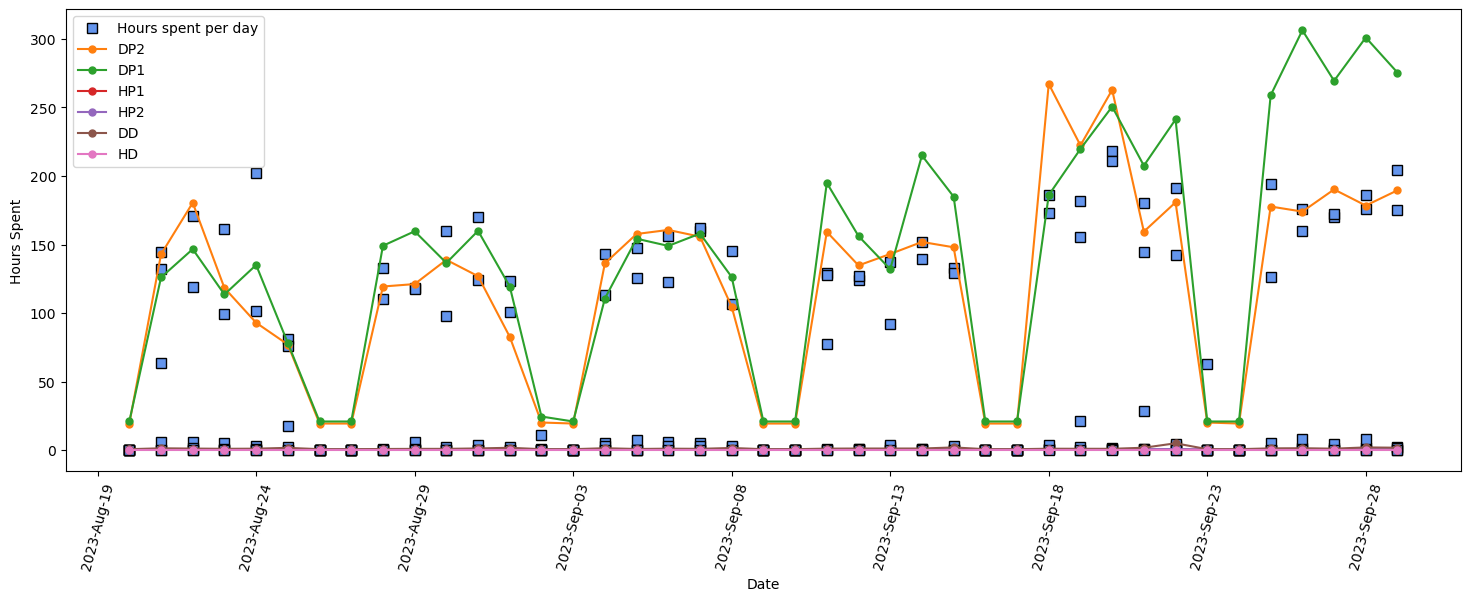

In [753]:
date = df['DATE'][train_size:]
num_teams = df['TEAMNAME'].nunique()

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(date, inv_y / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Hours spent per day')
# ax.plot(date, inv_yhat / 3600, 
#         linestyle='',
#         marker='o',
#         markersize=5,
#         color='red',
#         label='Prediction')
for i in range(num_teams):
        ax.plot(date.unique(), inv_yhat[i::num_teams] / 3600, 
                linestyle='-',
                marker='o',
                markersize=5,
                # get color from color cycle
                color=ax._get_lines.get_next_color(),
                label=list(codes.keys())[i])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Hours Spent')
plt.xticks(rotation=75)
ax.legend(loc='upper left')
plt.show()

In [754]:
# MAE
mae = mean_absolute_error(inv_y, inv_yhat) / 3600
print('MAE: %.3f' % (mae))

MAE: 11.222


In [755]:
# # design network
# np.random.seed(1234)
# tf.random.set_seed(1234)

# tf.keras.utils.set_random_seed(1234)
# tf.config.experimental.enable_op_determinism()

# optim = optimizers.Adam(lr=0.0005, beta_1=0.99, beta_2=0.999, amsgrad=False)
# model = Sequential()
# model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# # model.add(Dropout(0.1))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mae', optimizer=optim)

# # fit network
# history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # plot history
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()